In [2]:
import ismrmrd
import rtoml
import os
import fnmatch
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import pyfftw
from pathlib import Path
import copy


# Read config
with open('config.toml', 'r') as cf:
    cfg = rtoml.load(cf)

DATA_ROOT = cfg['DATA_ROOT']
DATA_DIR = cfg['data_folder']
raw_file = cfg['raw_file']
prewhiten = cfg['editer']['prewhiten']
autoselect = cfg['editer']['autosniffer_select']
remove_os = cfg['saving']['remove_os']

data_dir_path = os.path.join(DATA_ROOT, DATA_DIR, 'raw/h5')
if raw_file.isnumeric():
    raw_file_ = fnmatch.filter(os.listdir(data_dir_path), f'meas_MID*{raw_file}*.h5')[0]
    ismrmrd_data_fullpath = os.path.join(data_dir_path, raw_file_)
    ismrmrd_noise_fullpath = os.path.join(DATA_ROOT, DATA_DIR, 'raw/noise', f'noise_{raw_file_}')
elif raw_file.startswith('meas_MID'):
    raw_file_ = raw_file
    ismrmrd_data_fullpath = os.path.join(data_dir_path, raw_file)
else:
    print('Could not find the file. Exiting...')
    exit(-1)


In [3]:
# Read the data in
print(f'Reading {ismrmrd_data_fullpath}...')
with ismrmrd.Dataset(ismrmrd_data_fullpath) as dset:

    n_acq = dset.number_of_acquisitions()
    print(f'There are {n_acq} acquisitions in the file. Reading...')

    acq_list = []
    for ii in range(n_acq):
        acq_list.append(dset.read_acquisition(ii))

    n_wf = dset.number_of_waveforms()
    print(f'There are {n_wf} waveforms in the dataset. Reading...')

    wf_list = []
    for ii in range(n_wf):
        wf_list.append(dset.read_waveform(ii))
    
    hdr = ismrmrd.xsd.CreateFromDocument(dset.read_xml_header())

# get the k-space trajectory based on the metadata hash.
traj_name = hdr.userParameters.userParameterString[1].value

# load the .mat file containing the trajectory
traj = loadmat(os.path.join(DATA_ROOT, DATA_DIR, traj_name), squeeze_me=True)

n_unique_angles = int(traj['param']['repetitions'])

kx = traj['kx'][:,:]
ky = traj['ky'][:,:]
dt = float(traj['param']['dt'])
msize = int(10 * traj['param']['fov'] / traj['param']['spatial_resolution'])
pre_discard = int(traj['param']['pre_discard'])
w = traj['w']

# Convert raw data and trajectory into convenient arrays
ktraj = np.stack((kx, -ky), axis=2)
# find max ktraj value
kmax = np.max(np.abs(kx + 1j * ky))
# swap 0 and 1 axes to make repetitions the first axis (repetitions, interleaves, 2)
ktraj = np.swapaxes(ktraj, 0, 1)
ktraj = 0.5 * (ktraj / kmax) * msize

data = [arm.data[:,:] for arm in acq_list]
dcf = np.tile(w[None, :], (n_acq, 1))
coord = [ktraj[ii%n_unique_angles,:,:] for ii in range(n_acq)]

data = np.array(data)
data = np.transpose(data, axes=(2, 0, 1))
coord = np.array(coord, dtype=np.float32)
coord = np.transpose(coord, axes=(2, 1, 0))


Reading /server/home/btasdelen/MRI_DATA/pilottone/vol0929_20240725/raw/h5/meas_MID00547_FID18204_pulseq2D_fire_spiralga_400mV_24MHz.h5...
There are 14400 acquisitions in the file. Reading...
There are 4431 waveforms in the dataset. Reading...


Reading /server/home/btasdelen/MRI_DATA/pilottone/vol0929_20240725/raw/noise/noise_meas_MID00547_FID18204_pulseq2D_fire_spiralga_400mV_24MHz.h5...
There are 1842 acquisitions in the file. Reading...
Prewhitening the raw data...


/server/home/btasdelen/micromamba/envs/pilottone/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


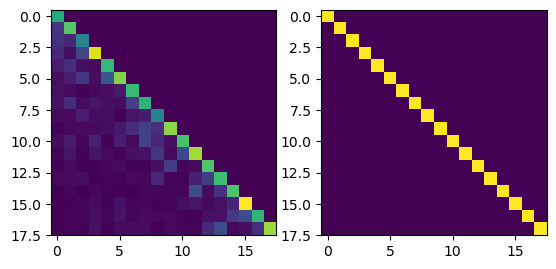

In [4]:
# Read the noise data in
print(f'Reading {ismrmrd_noise_fullpath}...')
with ismrmrd.Dataset(ismrmrd_noise_fullpath) as dset_noise:
    n_cal_acq = dset_noise.number_of_acquisitions()
    print(f'There are {n_cal_acq} acquisitions in the file. Reading...')

    cal_list = []
    for ii in range(n_cal_acq):
        cal_list.append(dset_noise.read_acquisition(ii))

noise_list = []

for cal_ in cal_list:
    if cal_.is_flag_set(ismrmrd.ACQ_IS_NOISE_MEASUREMENT):
        noise_list.append(cal_.data)

noise = np.transpose(np.asarray(noise_list), (1,0,2)).reshape((noise_list[0].shape[0], -1))

if prewhiten:
    from reconstruction.coils import apply_prewhitening, calculate_prewhitening

    print('Prewhitening the raw data...')
    dmtx = calculate_prewhitening(noise)

    data = apply_prewhitening(np.transpose(data, (2,0,1)), dmtx).transpose((1,2,0))

    dmtx2 = calculate_prewhitening(apply_prewhitening(noise, dmtx))

    _,axs = plt.subplots(1,2)
    axs[0].imshow(np.abs(dmtx))
    axs[1].imshow(np.abs(dmtx2))
    plt.show()


In [5]:
%matplotlib widget
from editer import autopick_sensing_coils

coil_name = []

for clbl in hdr.acquisitionSystemInformation.coilLabel:
    coil_name.append(clbl.coilName)

coil_name = np.asarray(coil_name)


f0 = hdr.experimentalConditions.H1resonanceFrequency_Hz
df = 1/(dt*data.shape[0])

t_acq_start = acq_list[0].acquisition_time_stamp*2.5e-3 # [2.5ms] -> [s]
t_acq_end = acq_list[-1].acquisition_time_stamp*2.5e-3
time_acq = np.linspace(t_acq_start, t_acq_end, n_acq) # Interpolate for TR, as TR will not be a multiple of time resolution.
time_pt = time_acq - t_acq_start
samp_time_pt = time_acq[1] - time_acq[0]

from scipy.signal.windows import tukey
ksp_window = tukey(data.shape[0]*2, 0.01)
ksp_window = ksp_window[data.shape[0]:, None, None]

# TEST auto coil selection
from pilottone.signal import to_hybrid_kspace

f_pt = 24e6 # [Hz]
f_diff = f0 - f_pt


if autoselect:
    # mri_coils, sensing_coils = autopick_sensing_coils(data, f_emi=f_diff, bw_emi=100e3, bw_sig=200e3, f_samp=1/dt, ratio_th=0.1)
    mri_coils, sensing_coils = autopick_sensing_coils(data, f_emi=f_diff, bw_emi=100e3, bw_sig=200e3, f_samp=1/dt, n_sensing=8)

else:
    mri_coils = np.arange(15, dtype=int)
    sensing_coils = np.array([15, 16, 17], dtype=int)

print(f"Coils to be used as sniffers: {coil_name[sensing_coils.astype(int)]}")

ksp_measured = data[:,:,mri_coils]*ksp_window
ksp_sniffer  = data[:,:,sensing_coils]*ksp_window


/server/home/btasdelen/micromamba/envs/pilottone/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


Coils to be used as sniffers: ['Spine_18:1:S4T' 'Spine_18:1:S4P' 'Spine_18:1:S4S' 'Spine_18:1:S1T'
 'Spine_18:1:S3T' 'Spine_18:1:S2T' 'Body_6:1:B21' 'Spine_18:1:S3S']


/server/home/btasdelen/micromamba/envs/pilottone/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


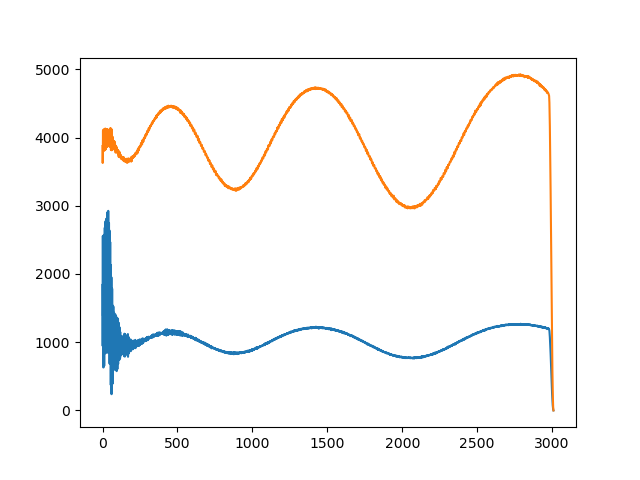

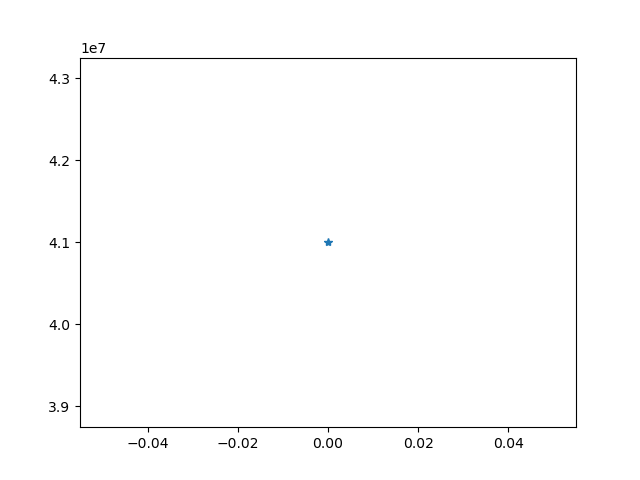

In [7]:
## TODO (IDEA): PCA sniffer coils before weighting and subtracting from k-space to "denoise" them. Compare SNR with and without.

from scipy.sparse.linalg import svds
# from scipy.linalg import svd
U, S, V = svds(ksp_sniffer.reshape((ksp_sniffer.shape[0]*ksp_sniffer.shape[1], -1)), k=1)
ksp_sniffer2 = (U@np.diag(S))@V
ksp_sniffer2 = ksp_sniffer2.reshape((ksp_sniffer.shape[0], ksp_sniffer.shape[1], ksp_sniffer.shape[2]))
plt.figure()
plt.plot(np.sort(S), "*")
plt.figure()
plt.plot(np.abs(ksp_measured[:,0,0].squeeze()))
plt.plot(np.abs(ksp_sniffer2[:,0,0].squeeze()))
plt.show()

In [10]:
import time
import multiprocessing as mp
from editer import apply_editer
# mp.set_start_method('spawn')

# ===============================================================
# Prepare EDITER weights and inputs
# ===============================================================
start_time = time.time()

# emi_hat = np.zeros(ksp_measured.shape, dtype=np.complex64)


dk = [3, 0]

w = np.concatenate((np.zeros((pre_discard, coord.shape[2])), np.sqrt(coord[0,:,:]**2 + coord[1,:,:]**2))).astype(np.float32)
n_pe = round(1000 / hdr.sequenceParameters.TR[0])  # 4 * Nlines / Nrep

editer_params = {
    'grouping_method': "uniform",  # "uniform", "corr_orig"
    'max_lines_per_group': n_pe,   # Max number of lines in a group
    'dk': dk                     # Convolution kernel size in kx and ky directions 
}

chs = range(ksp_measured.shape[2])

def process_channel(ch):
    est_emi_ch, _ = apply_editer(ksp_measured[:, :, ch], ksp_sniffer2, editer_params, w)
    return est_emi_ch
# results = [process_channel(ch_i) for ch_i in chs] # Single process for dbg
with mp.Pool(processes=len(chs)) as pool:
    results = pool.map(process_channel, chs)

emi_hat = np.stack(results, axis=2)
ksp_emicorr = ksp_measured - emi_hat

print(f"Elapsed time: {time.time() - start_time} seconds")



Elapsed time: 149.46126437187195 seconds


## Profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


/server/home/btasdelen/micromamba/envs/pilottone/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


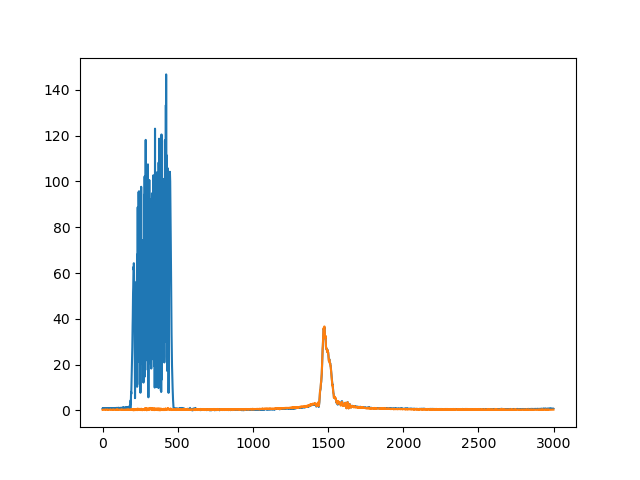

Timer unit: 1 s

Total time: 16.1636 s
File: /tmp/ipykernel_3379645/2048943940.py
Function: est_emi_gpu at line 80

Line #      Hits         Time  Per Hit   % Time  Line Contents
    80                                           def est_emi_gpu(signal_in: npt.NDArray[np.complex64], sniffer: npt.NDArray[np.complex64], line_grps: list[npt.NDArray], dk: list[int], w: npt.NDArray[np.float32]):
    81                                               
    82         1          0.0      0.0      0.1      w_gpu = cp.asarray(w)
    83                                               # sniffer_gpu = cp.asarray(sniffer) # Pre-weight for GPU case
    84                                               # sniffer = sniffer # Pre-weight for GPU case
    85                                           
    86                                               # signal_in_gpu = cp.asarray(signal_in)
    87                                               # del w_gpu
    88                                               # cp

In [29]:
# %load_ext line_profiler
# %lprun -u 1 -f est_emi_gpu apply_editer(ksp_measured[:, :, 0], ksp_sniffer2, editer_params, w)

plt.figure()
plt.plot(np.abs(to_hybrid_kspace(ksp_measured[pre_discard:,0,0])))
plt.plot(np.abs(to_hybrid_kspace(ksp_emicorr[pre_discard:,0,0])))


# Create a new MRD dataset, use the original as a template, and write corrected k-space into it.

In [8]:
n_samp = ksp_emicorr.shape[0]

if remove_os:
    ksp_emicorr = pyfftw.byte_align(ksp_emicorr)

    keepOS = np.concatenate([np.arange(n_samp // 4), np.arange(n_samp * 3 // 4, n_samp)])
    ifft_ = pyfftw.builders.ifft(ksp_emicorr, n=n_samp, axis=0, threads=32, planner_effort='FFTW_ESTIMATE')
    # ksp_emicorr = ifft(ksp_emicorr, axis=0)
    ksp_emicorr = ifft_()

    fft_ = pyfftw.builders.fft(ksp_emicorr[keepOS, :, :], n=n_samp//2, axis=0, threads=32, planner_effort='FFTW_ESTIMATE')
    # ksp_emicorr = fft(ksp_emicorr[keepOS, :, :], axis=0)
    ksp_emicorr = fft_()
    n_samp = n_samp // 2


output_dir_fullpath = os.path.join(DATA_ROOT, DATA_DIR, 'raw', 'h5_proc')
output_data_fullpath = os.path.join(output_dir_fullpath, f'{raw_file_[:-3]}_editer.h5')
print('Saving to ' + output_data_fullpath)

Path.mkdir(Path(output_dir_fullpath), exist_ok=True)

# Add EDITER parameters to XML header.
new_hdr = copy.deepcopy(hdr)
new_hdr.userParameters.userParameterLong.append(ismrmrd.xsd.userParameterLongType('EDITER_kx', editer_params['dk'][0]))
new_hdr.userParameters.userParameterLong.append(ismrmrd.xsd.userParameterLongType('EDITER_ky', editer_params['dk'][1]))
new_hdr.userParameters.userParameterLong.append(ismrmrd.xsd.userParameterLongType('EDITER_maxNoLines', editer_params['max_lines_per_group']))
new_hdr.userParameters.userParameterString.append(ismrmrd.xsd.userParameterStringType('processing', 'EDITER'))
new_hdr.userParameters.userParameterString.append(ismrmrd.xsd.userParameterStringType('EDITER_groupingAlgo', editer_params['grouping_method']))
new_hdr.acquisitionSystemInformation.coilLabel = [hdr.acquisitionSystemInformation.coilLabel[ch_i] for ch_i in mri_coils]
new_hdr.acquisitionSystemInformation.receiverChannels = len(new_hdr.acquisitionSystemInformation.coilLabel)

# Copy and fix acquisition objects
new_acq_list = []

for acq_i, acq_ in enumerate(acq_list):
    new_head = copy.deepcopy(acq_.getHead())
    new_head.active_channels = len(new_hdr.acquisitionSystemInformation.coilLabel)
    new_head.available_channels = len(new_hdr.acquisitionSystemInformation.coilLabel)
    if remove_os:
        new_head.number_of_samples = ksp_emicorr.shape[0]
        new_head.center_sample = pre_discard//2

    new_acq_list.append(ismrmrd.Acquisition(head=new_head, data=np.ascontiguousarray(ksp_emicorr[:,acq_i,:].squeeze().T.astype(np.complex64))))

with ismrmrd.Dataset(output_data_fullpath, create_if_needed=True) as new_dset:
    for acq_ in new_acq_list:
        new_dset.append_acquisition(acq_)

    for wave_ in wf_list:
        new_dset.append_waveform(wave_)

    new_dset.write_xml_header(ismrmrd.xsd.ToXML(new_hdr))


Saving to /server/home/btasdelen/MRI_DATA/pilottone/vol0912_20240626/raw/h5_proc/meas_MID00291_FID16400_pulseq2D_fire_spiralga_1000mV_24MHz_editer.h5


/server/home/btasdelen/micromamba/envs/pilottone/lib/python3.10/site-packages/h5py/_hl/filters.py:250: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  chunks = guess_chunk(shape, maxshape, dtype.itemsize)
